In [1]:
%matplotlib inline
import requests
import psycopg2
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pgconn = psycopg2.connect(database='postgis', host='iemdb', user='nobody')
cursor = pgconn.cursor()
cursor.execute("""
    with zones as (
        SELECT ugc, ST_x(centroid) as lon, ST_y(centroid) as lat from ugcs where
        substr(ugc, 1, 3) = 'IAZ' and end_ts is null
    ), bz as (
        SELECT ugc, issue from warnings where substr(ugc, 1, 3) = 'IAZ' and phenomena = 'BZ'
        and significance ='W'
    )
    select b.ugc, issue, lon, lat from bz b JOIN zones z on (b.ugc = z.ugc)
    ORDER by issue ASC
""")
data = [[], [], [], [], [], [], []]
for row in cursor:
    dt = row[1]
    lon = row[2]
    lat = row[3]
    sts = dt - datetime.timedelta(hours=(24 * 3))
    ets = dt + datetime.timedelta(hours=(24 * 3))
    uri = ("https://mesonet.agron.iastate.edu/iemre/multiday/" +
           sts.strftime("%Y-%m-%d") + "/" + ets.strftime("%Y-%m-%d") + "/" +
           str(lat) + "/" + str(lon) + "/json")
    j = requests.get(uri).json()
    if 'data' not in j:
        print("ERROR: %s %s" % (dt, j))
        continue
    for i in range(len(j['data'])):
        data[i].append(j['data'][i]['daily_high_f'])
    print row[0], dt, j['data'][0]['daily_high_f'], j['data'][-1]['daily_high_f']

 IAZ040 2007-02-24 04:20:00-06:00 48.0 35.0
IAZ051 2007-02-24 04:20:00-06:00 51.98 30.2
IAZ054 2007-02-24 04:20:00-06:00 44.96 30.92
IAZ041 2007-02-24 04:20:00-06:00 48.0 32.0
IAZ052 2007-02-24 04:20:00-06:00 51.98 30.2
IAZ053 2007-02-24 04:20:00-06:00 48.0 32.0
IAZ042 2007-02-24 04:20:00-06:00 48.0 32.0
IAZ019 2007-02-24 15:41:00-06:00 43.0 30.2
IAZ008 2007-02-24 15:41:00-06:00 42.8 28.94
IAZ030 2007-02-24 15:41:00-06:00 48.2 32.0
IAZ010 2007-02-24 15:41:00-06:00 45.0 32.0
IAZ029 2007-02-24 15:41:00-06:00 48.0 32.0
IAZ018 2007-02-24 15:41:00-06:00 42.8 28.94
IAZ011 2007-02-24 15:41:00-06:00 45.0 32.0
IAZ009 2007-02-24 15:41:00-06:00 43.0 30.2
IAZ037 2007-02-24 15:45:00-06:00 54.0 32.0
IAZ016 2007-02-24 15:45:00-06:00 45.0 30.2
IAZ025 2007-02-24 15:45:00-06:00 46.0 28.4
IAZ039 2007-02-24 15:45:00-06:00 46.94 30.2
IAZ006 2007-02-24 15:45:00-06:00 42.8 28.94
IAZ007 2007-02-24 15:45:00-06:00 42.8 28.94
IAZ049 2007-02-24 15:45:00-06:00 54.0 32.0
IAZ017 2007-02-24 15:45:00-06:00 42.8 28.94


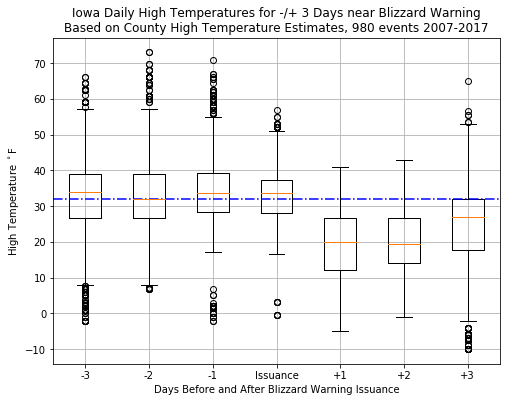

In [5]:
(fig, ax) = plt.subplots(1, 1, figsize=(8, 6))
res = ax.boxplot(data)
ax.set_title(("Iowa Daily High Temperatures for -/+ 3 Days near Blizzard Warning\n"
              "Based on County High Temperature Estimates, %s events 2007-2017") % (len(data[0]),))
ax.set_xticklabels(["-3", "-2", "-1", "Issuance", "+1", "+2", "+3"])
ax.grid(True)
ax.axhline(32, color='b', lw=1.5, linestyle='-.')
ax.set_xlabel("Days Before and After Blizzard Warning Issuance")
ax.set_ylabel("High Temperature $^\circ$F")
ax.set_yticks(range(-10, 80, 10))
fig.savefig("170224.png")